# Проект 3. Kaggle. Прогнозирование рейтинга отеля на Booking.(+ML)

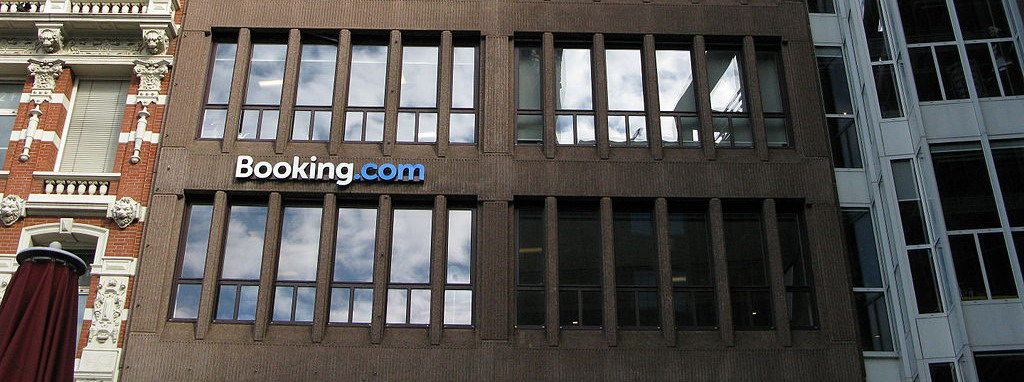

*Содержание*
-  Загрузка и очистка данных
-  Конструирование новых признаков
-  Обучение модели (RandomForestRegressor)
-  Вывод

In [ ]:
# устанавливаем недостоющие модули по необходимости
# %pip install nltk category_encoders

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
#plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6,4)

from IPython.display import display

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
import category_encoders as ce

# тесты
from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import chi2 # хи-квадрат

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))     

## Загрузка и подготовка данных

In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42   

# Подгрузим наши данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [ ]:
df_train.info()

In [ ]:
df_train.head(2)

In [ ]:
df_test.info()

In [ ]:
df_test.head(2)

In [ ]:
sample_submission.head(2)

In [ ]:
sample_submission.info()

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# Освободим память при локальной обработки
del df_train, df_test

In [ ]:
data.info()

In [ ]:
data.describe(include='object')

In [ ]:
data.describe().round(2)

In [ ]:
# Разгрузим память, ускорим обработку
category_columns = ['hotel_address', 'hotel_name', 'reviewer_nationality']
data[category_columns] = data[category_columns].astype('category')

## Очистка и заполнение пропусков

In [ ]:
# Есть дубли, но мало. Ну... есть и есть.
data.duplicated().sum()

In [ ]:
# Пропуски в локации
data.isna().sum()

In [ ]:
# Выделим страну из адреса отеля и заполним среднем по широте и дологоте
data['country'] = data['hotel_address'].str.extract(r'.+ (.+)$')\
    .astype('category').replace('Kingdom', 'United Kingdom')

In [ ]:
lat_mean = data.groupby('country')['lat'].mean()
lat_mean

In [ ]:
lng_mean = data.groupby('country')['lng'].mean()
lng_mean

In [ ]:
# Вариант 1 (наглядный)
def set_lat(x:pd.Series):
    return lat_mean[x['country']]
#--------------------------------
data.loc[data['lat'].isna(),'lat'] = data[data['lat'].isna()].apply(set_lat, axis=1)
#data['lat'].isna().sum()

In [ ]:
# Вариант 2 (лямбда)
data.loc[data['lng'].isna(),'lng'] = \
    data[data['lng'].isna()].apply(lambda x: lng_mean[x['country']], axis=1)
#data['lng'].isna().sum()

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(data.sample(30000), x='lng', y='lat', hue='country')
plt.title('Разброс отелей по координатам');


In [ ]:
data['review_date'] = pd.to_datetime(data['review_date'],format= "%m/%d/%Y")
data['days_since_review'] = data['days_since_review'].str.extract(r'(\d+) day')
data['days_since_review'] = pd.to_numeric(data['days_since_review'], downcast='integer')

## Создание новых признаков

In [ ]:
# Месяц ревью как признак "сезона"
data['month'] = data['review_date'].dt.month.astype(int)

In [ ]:
# "Цель прибывания" или что то типа того. Разделим на деловую и просто пошарахаться/шоппинг
data['purpose_arrival'] = data['tags'].str.extract(r'([LB].+) trip') # .?\'?
print(data['purpose_arrival'].value_counts())

# Возмем отдельно только признак "бизнес-тур, а все остальное - в остальное. 
data['purpose_arrival'] = data['purpose_arrival'].apply(lambda x: 1 if x=='Business' else 0)

In [ ]:
# Заявленное время пребывания в сутках(днях, вечерах, ночах)
data['stayed_nights'] = data['tags'].str.extract(r'Stayed (\d+) night').fillna(0).astype(int)

In [ ]:
# Размер компании
data['is_solo_travel'] = data['tags'].str.contains(r'Solo traveler')
data['is_couple_travel'] = data['tags'].str.contains(r'Couple')
data['is_group_travel'] = data['tags'].str.contains(r'Group')

In [ ]:
# выделим из топ50 по количеству топ10 с высоким средним рейтингом и топ10 с низким
by_nationality = data.groupby('reviewer_nationality')[['reviewer_nationality', 'reviewer_score']].agg(['count', 'mean']).round(1)

display(by_nationality.sort_values(by=('reviewer_score', 'count'), ascending=False).head(50)\
    .sort_values(by=('reviewer_score', 'mean'), ascending=False).head(10))

top_10_nation = by_nationality.sort_values(by=('reviewer_score', 'count'), ascending=False).head(50)\
    .sort_values(by=('reviewer_score', 'mean'), ascending=False).head(10).index.to_list()

In [ ]:
display(by_nationality.sort_values(by=('reviewer_score', 'count'), ascending=False).head(50)\
    .sort_values(by=('reviewer_score', 'mean'), ascending=True).head(10))

low_10_nation = by_nationality.sort_values(by=('reviewer_score', 'count'), ascending=False).head(50)\
    .sort_values(by=('reviewer_score', 'mean'), ascending=True).head(10).index.to_list()

In [ ]:
# бинарный признак top_10_nation по среднему рейтингу
data['top_10_nation'] = data['reviewer_nationality'].apply(lambda x: 1 if x in top_10_nation else 0)
data[data['top_10_nation']==1][['reviewer_nationality']].sample(7)

In [ ]:
# бинарный признак low_10_nation по среднему рейтингу
data['low_10_nation'] = data['reviewer_nationality'].apply(lambda x: 1 if x in low_10_nation else 0)
data[data['low_10_nation']==1][['reviewer_nationality']].sample(7)

## Отдельный анализ положительных и отрицательных отзывов
-  В позитивных меняем "No Positive", в негативных "No Negative" на их смысловые противоположности. с диалектикой у nltk не очень.
-  склеиваем negative_review + positive_review и анализируем через nltk 


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Пойдем самым линейным путем
# в "No Negative" вложим позитивную коннотацию
data['negative_review_'] = data['negative_review'].str.replace("No Negative", "Positive")

# в "No Positive" вложим негативную коннотацию
data['positive_review_'] = data['positive_review'].str.replace("No Positive", "Negative")

In [ ]:
data[['negative_review_']].value_counts().head(7)

In [ ]:
data[['positive_review_']].value_counts().head(7)

In [ ]:
sent_analyzer = SentimentIntensityAnalyzer()
def _analyzer(review):
    result = sent_analyzer.polarity_scores(review)
    return pd.Series([result['neg'], result['pos']])

In [ ]:
%%time
# склеим ревью и расчитаем показатели
data[['neg_ratio', 'pos_ratio']] = (data['negative_review_'] + ';' + data['positive_review_']).apply(_analyzer)
data.drop(columns=['negative_review_', 'positive_review_'], inplace=True)

In [ ]:
# Оценим в сэмплах
data[['negative_review', 'neg_ratio', 'positive_review', 'pos_ratio']].sample(10)

In [ ]:
train_mask = data['sample'] == 1
by_target = data[train_mask].groupby('reviewer_score')[['neg_ratio', 'pos_ratio']].mean()
sns.lineplot(by_target)
plt.title('Зависимость среднего рейтинга от коофициента\nколичества позитива и негатива в обзорах');

### Итог по анализу комментариев из ревью
Как видим, близкая к линейной зависимости целевой переменной от комбинации позитивной и негативной коннотации в коментариях ревью.

## Отбор признаков и обучение модели

In [ ]:
train_columns = [
    'average_score',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'total_number_of_reviews',
    # 'additional_number_of_scoring',
    'lat',
    'lng',
    'days_since_review',
    'stayed_nights',
    'neg_ratio', 
    'pos_ratio',
]

In [ ]:
#pearson, pearson, kendall
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_title('Карта корреляции числовых признаков')
matrix_corr = data[train_columns].corr(method='pearson')
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);

In [ ]:
train_cat_columns = [
    'month',
    'country',
    'is_solo_travel',
    'is_couple_travel',
    'is_group_travel',
    'purpose_arrival',
    'reviewer_nationality',
    'low_10_nation',
    'top_10_nation',
]

In [ ]:
#pearson, spearman, kendall
heatmap_params = dict(annot=True, vmin=-1, vmax=1, center=0, linewidths=0.1, cmap='coolwarm')
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Карта корреляции категориальных признаков')
matrix_corr = data[train_cat_columns+['reviewer_score','average_score']].corr(method='spearman')
sns.heatmap(matrix_corr, ax=ax, **heatmap_params);

In [ ]:
data = data[train_columns + train_cat_columns +['reviewer_score', 'sample']]
data.info()

In [ ]:
#

### Нормализация, стандартизация и кодирование признаков

In [ ]:
# Все булевые признаки-индикаторы, если есть, переводим в числовые [0,1]

# convert bool fields to int
for column in data.columns:
    if data[column].dtype == 'bool':
        data[column] = data[column].astype(int)

In [ ]:
# Binary Encode
encode_cols=['reviewer_nationality']
ce_binary = ce.BinaryEncoder(cols=encode_cols)
data = ce_binary.fit_transform(data)

In [ ]:
# One Hot Encode
encode_cols=['month', 'country'] # 
ce_onehot = ce.OneHotEncoder(cols=encode_cols, use_cat_names=True)
data = ce_onehot.fit_transform(data)
data.head(2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
_scaler = MinMaxScaler()
_scaler.fit(data[train_columns])
data[train_columns] = _scaler.fit_transform(data[train_columns])
data[train_columns].describe().round(2)

In [ ]:
#========================================================================

### Формирование тренировочного датасета

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

In [ ]:
train_data.info()

In [ ]:
test_data.info()

### Обучение модели

In [ ]:
X = train_data.drop(['reviewer_score'], axis=1)
y = train_data['reviewer_score'].values

#### Оценка признаков на значимость (anova, хи-квадрат)

In [ ]:
## непрерывные признаки
num_cols = [x for x in X.columns if X[x].nunique()>2]

if num_cols:
    y_ = y.astype('int')
    from sklearn.feature_selection import f_classif # anova
    imp_num = pd.Series(f_classif(X[num_cols], y_)[0], index = num_cols)
    imp_num.sort_values(inplace = True)
    imp_num.plot(kind = 'barh');

In [ ]:
# категориальные признаки
cat_cols = [x for x in X.columns if X[x].nunique()==2]

if cat_cols:
    y_ = y.astype('int')
    from sklearn.feature_selection import chi2 # хи-квадрат
    imp_cat = pd.Series(chi2(X[cat_cols], y_)[0], index=cat_cols)
    imp_cat.sort_values(inplace=True)
    imp_cat.plot(kind='barh', figsize=(7,7));

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
params = dict(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1,
    random_state=RANDOM_SEED)

model = RandomForestRegressor(**params)

In [ ]:
# проверяем
print('test_data', test_data.shape)
print('---\ntrain_data', train_data.shape)
print('X', X.shape)
print('X_train', X_train.shape)
print('X_test', X_test.shape)

In [ ]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

In [ ]:
%%time
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

# Наше Все
print('--------------------------')
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('--------------------------')

# MAPE: 0.1277731592693772

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
fig, ax = plt.subplots(figsize=(10,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh',ax=ax);

## Подготовка и выгрузка submission

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission.info()

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)